In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sktime.utils.plotting import plot_series as ploting_series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Things to process in data 

Reports null for 20 min every week, So that 20 their would be a jump observed of 40 minutes in the data

Data only from 5am to 11:59pm 

More demand on Holiday =>  seasonality in data we need to remove by differencing

All those number plate differe by one character are same 

In [ ]:
def is_similar(v1, v2):
    if len(v1) != len(v2):
        return False
    differences = sum(1 for a, b in zip(v1, v2) if a != b)
    return differences == 1  # Return True if they differ by exactly one character

In [217]:
# Function to calculate MASE (Mean Absolute Scaled Error)
def mase(y_true, y_pred, y_train):
    naive_forecast = np.roll(y_train, shift=1)[1:]
    mae_naive = np.mean(np.abs(y_train[1:] - naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / mae_naive


In [218]:
# Function to calculate MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [219]:
def is_similar(v1, v2):
    if len(v1) != len(v2):
        return False
    differences = sum(1 for a, b in zip(v1, v2) if a != b)
    return differences == 1  # Return True if they differ by exactly one character

In [220]:
# Group similar vehicle numbers
def group_similar_vehicle_numbers(vehicle_numbers):
    vehicle_groups = {}
    seen = set()
    
    for vehicle in vehicle_numbers:
        if vehicle in seen:
            continue
        similar_group = {vehicle}
        seen.add(vehicle)
        
        # Compare with all other vehicles
        for other_vehicle in vehicle_numbers:
            if other_vehicle in seen:
                continue
            if is_similar(vehicle, other_vehicle):
                similar_group.add(other_vehicle)
                seen.add(other_vehicle)
        
        # Use the most frequent vehicle number in the group as the representative
        representative = max(similar_group, key=lambda x: list(vehicle_numbers).count(x))
        
        # Update mapping only for vehicles that are not the representative
        for v in similar_group:
            if v != representative:  # Avoid mapping to itself
                vehicle_groups[v] = representative

    return vehicle_groups

In [221]:
# Function to plot the time series
def plot_series(train, test, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label="Train Data")
    plt.plot(test.index, test, label="Test Data", color='orange')
    plt.plot(test.index, forecast, label="Forecast", color='green')
    plt.title(title)
    plt.legend()
    plt.show()

In [222]:
# Function to plot ACF and PACF in a 1x2 subplot
def plot_acf_pacf(data, lags):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    plot_acf(data, lags=lags, ax=ax[0])
    ax[0].set_title('Autocorrelation (ACF)')
    
    plot_pacf(data, lags=lags, ax=ax[1])
    ax[1].set_title('Partial Autocorrelation (PACF)')
    
    plt.tight_layout()
    plt.show()

In [236]:
# Load the parking lot data
df = pd.read_csv('./parkingLot (1).csv')
# Droping those values where camera didn't worked
# So make a dict of the day camera didn't worked and number of cars passed by during that time in order to update the vehicles per day 

# Now processing the data
df['timestamp'] = pd.to_datetime(df['timestamp'])

# It was observed that the Entries with and without filtering of operational hours were the same, so it was decided to not filter the data
# Beacuse only vehicles were exiting during non - operational hours and that would be helpful to find the avg time spent by a vehicle on a particular day , Also accounting for them would give the true number of vehicles entering per day 
# filter data for operational hours
# df = df[(df['timestamp'].dt.hour >= 5) & (df['timestamp'].dt.hour < 24)]

# Create a dictionary to keep track of vehicle counts during maintenance
maintenance_dict = {}
# Step through the operational DataFrame to identify NaN vehicle_no entries
for index, row in df.iterrows():
    if pd.isna(row['vehicle_no']):
        # Get the date of the maintenance
        maintenance_date = row['timestamp'].date().strftime('%Y-%m-%d')
        
        # Update the maintenance dictionary
        if maintenance_date not in maintenance_dict:
            maintenance_dict[maintenance_date] = 1
        else:
            maintenance_dict[maintenance_date] += 1

df_entry = df[df['camera_id'] == 1].copy()
daily_entry_count = df_entry.groupby(df_entry['timestamp'].dt.date).size()

# Display the daily entry counts
print(daily_entry_count)

df = df.dropna(subset=['vehicle_no']) 

# Now for the vehicles that dont have the either entry or exit time they are dropped , beacuse those'd vehicles other half i.e. exit or entry is marked during the maintenance time, So we can't find thier exact tie of leaving . 

# Separate camera data for entry (camera ID 001) and exit (camera ID 002)
df_entry = df[df['camera_id'] == 1].copy()
df_exit = df[df['camera_id'] == 2].copy()
# print(len(df_entry), len(df_exit))
# Merge entry and exit on vehicle_no to calculate time spent
merged_data = pd.merge(df_entry, df_exit, on='vehicle_no', suffixes=('_entry', '_exit'),how='outer',indicator=True)
merged_data['time_spent'] = (merged_data['timestamp_exit'] - merged_data['timestamp_entry']).dt.total_seconds() / 60.0  # in minutes
print(merged_data)
# Now uptil here all those data that have entry and exit time are merged and the time spent by them is calculated, And those who done have a pair of the entry and exit are also included in the data


timestamp
2024-09-12     886
2024-09-13     809
2024-09-14     925
2024-09-15    1073
2024-09-16     843
              ... 
2024-11-09     906
2024-11-10     944
2024-11-11     828
2024-11-12     806
2024-11-13     781
Length: 63, dtype: int64
      vehicle_no     timestamp_entry  camera_id_entry      timestamp_exit  \
0       MHUN7063 2024-09-12 05:00:00              1.0 2024-09-12 08:00:00   
1       MHYN4677 2024-09-12 05:00:00              1.0 2024-09-12 08:00:00   
2       MHEL6595 2024-09-12 05:00:00              1.0 2024-09-12 08:00:00   
3       MHNQ2590 2024-09-12 05:00:00              1.0 2024-09-12 08:20:00   
4       MHHA0518 2024-09-12 05:00:00              1.0                 NaT   
...          ...                 ...              ...                 ...   
54217   MHNT6986                 NaT              NaN 2024-11-13 14:40:00   
54218   MHIO9O71                 NaT              NaN 2024-11-13 16:00:00   
54219   1HZS7809                 NaT              NaN 2024-11-1

In [224]:
# This contains the non mathced data
non_matched_data = merged_data[merged_data['_merge'] != 'both']

# Get unique vehicle numbers and group them
unique_vehicle_numbers = non_matched_data['vehicle_no'].unique()
vehicle_number_mapping = group_similar_vehicle_numbers(unique_vehicle_numbers)

# Now update those entries which have similar vehicle numbers (i.e. differes by one)
for index in df.index:  # Use df.index to iterate over the actual index values
    original_vehicle_no = df.loc[index, 'vehicle_no']  # Access the vehicle_no column
    # Replace with mapped vehicle number if it exists in the mapping, else keep it the same
    df.at[index, 'vehicle_no'] = vehicle_number_mapping[original_vehicle_no] if original_vehicle_no in vehicle_number_mapping else original_vehicle_no

# Update the df_entry and df_exit dataframes
df_entry = df[df['camera_id'] == 1].copy()
df_exit = df[df['camera_id'] == 2].copy()
# Merge entry and exit on vehicle_no to calculate time spent
merged_data = pd.merge(df_entry, df_exit, on='vehicle_no', suffixes=('_entry', '_exit'))
merged_data['time_spent'] = (merged_data['timestamp_exit'] - merged_data['timestamp_entry']).dt.total_seconds() / 60.0  # in minutes

# When the non mathced entry was run it came to be same around(a diff of 2-3 , which is reasonable and we can afford) the number of maintainance data, which suggest that the number of vehicle which entered and exited during the maintenance time is very less and can be ignored

In [225]:
# Forecast total number of vehicles entering per day
df_entry['date'] = df_entry['timestamp'].dt.date
vehicles_per_day = df_entry.groupby('date').size().asfreq('D')
# Now use the maintanance data to update the vehicles per day
for date, count in maintenance_dict.items():
    vehicles_per_day.loc[date] += count

date
2024-09-12     886
2024-09-13     809
2024-09-14     925
2024-09-15    1073
2024-09-16     843
              ... 
2024-11-09     912
2024-11-10     944
2024-11-11     828
2024-11-12     806
2024-11-13     781
Freq: D, Length: 63, dtype: int64


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Vehicles Entering Per Day (Diff 7)'}>)

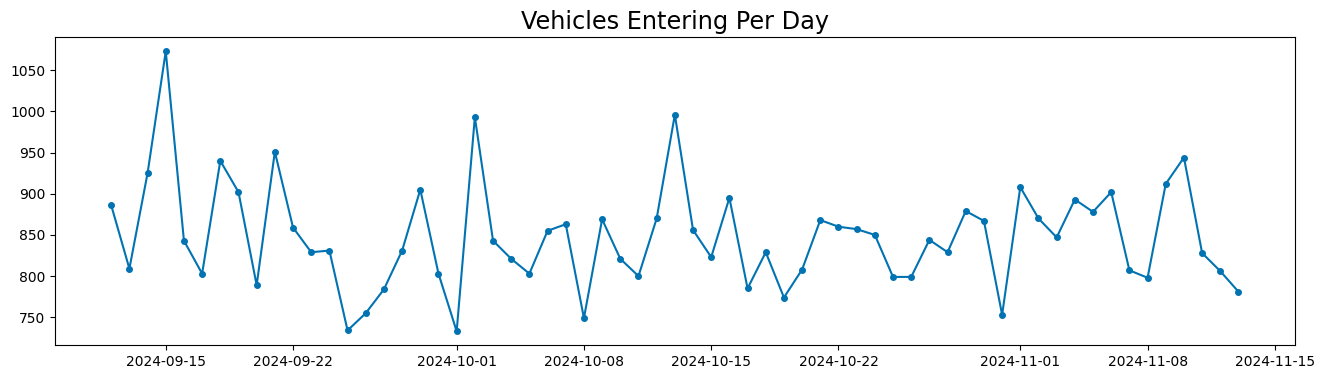

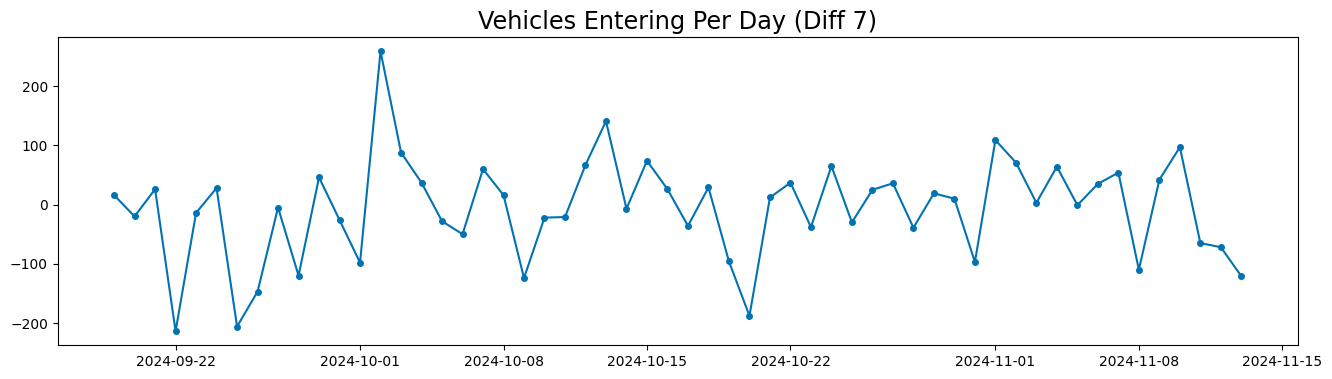

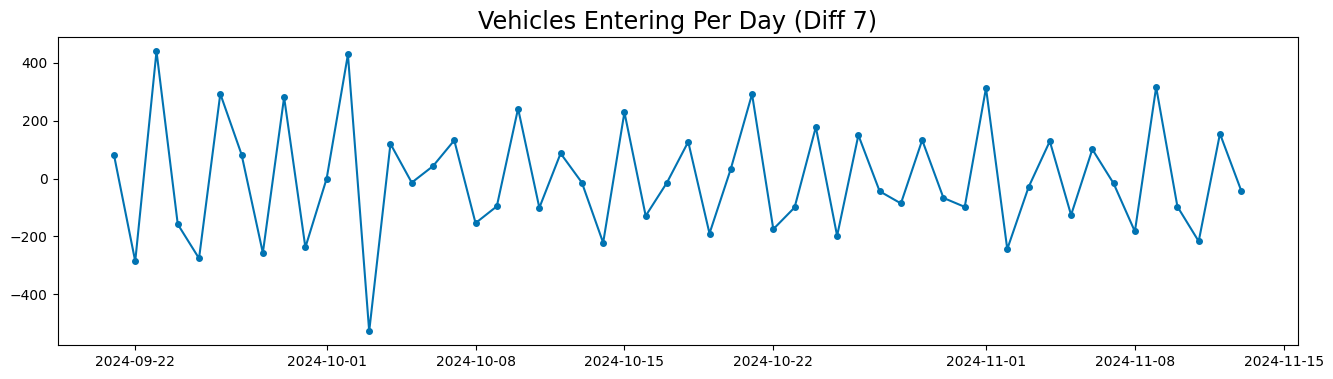

In [226]:
ploting_series(vehicles_per_day, title="Vehicles Entering Per Day")
vehicles_per_day_diff = vehicles_per_day.diff(periods=7).dropna()
# Now the plot of vehicles per day diff shows that the data is somehwat stationary , however we need further differencing to make it stationary
# Only applying d=2  we get a stationary data
vehicles_per_day_stationary = vehicles_per_day_diff.diff().diff().dropna()
ploting_series(vehicles_per_day_diff, title="Vehicles Entering Per Day (Diff 7)")
ploting_series(vehicles_per_day_stationary, title="Vehicles Entering Per Day (Diff 7)")

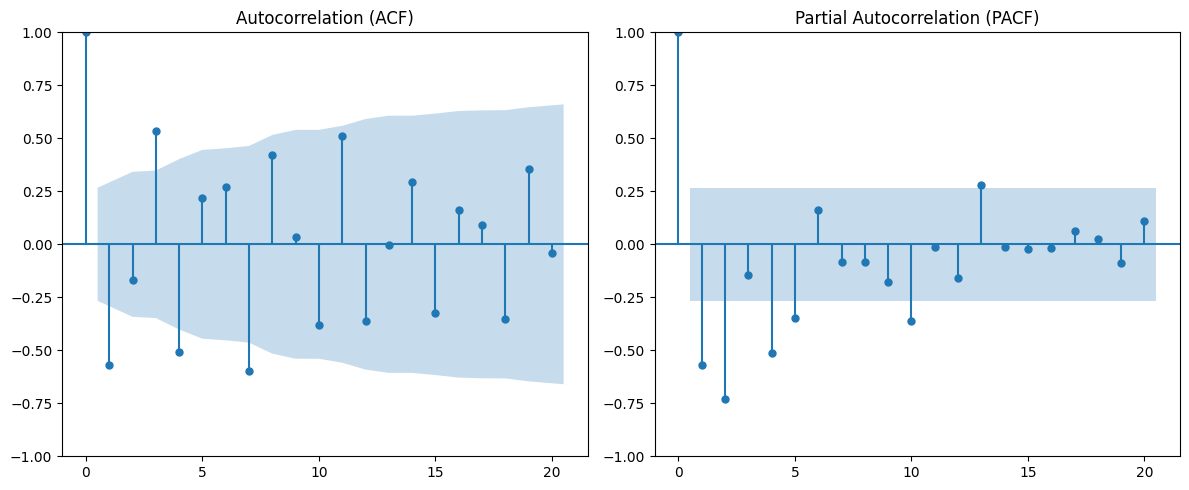

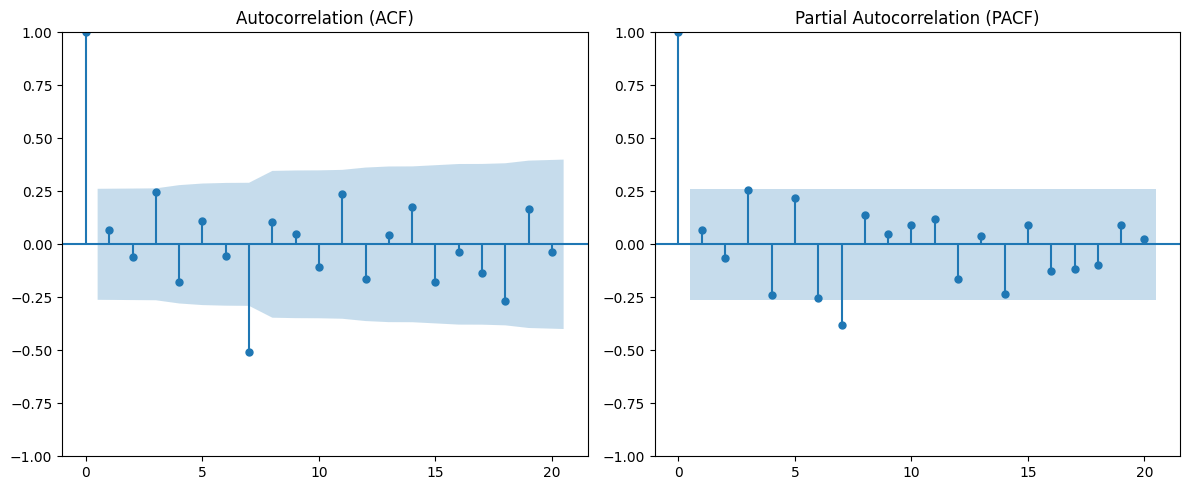

In [227]:
# Plotting ACF and PACF
plot_acf_pacf(vehicles_per_day_stationary, lags=20)
plot_acf_pacf(vehicles_per_day_diff, lags=20)


In [228]:
# Split data into training and testing sets
train_size = int(len(vehicles_per_day) * 0.8)
train_data, test_data = vehicles_per_day[:train_size], vehicles_per_day[train_size:]

# Ensure the index has a frequency for ARIMA
train_data.index = pd.date_range(start=train_data.index[0], periods=len(train_data), freq='D')
test_data.index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=len(test_data), freq='D')

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


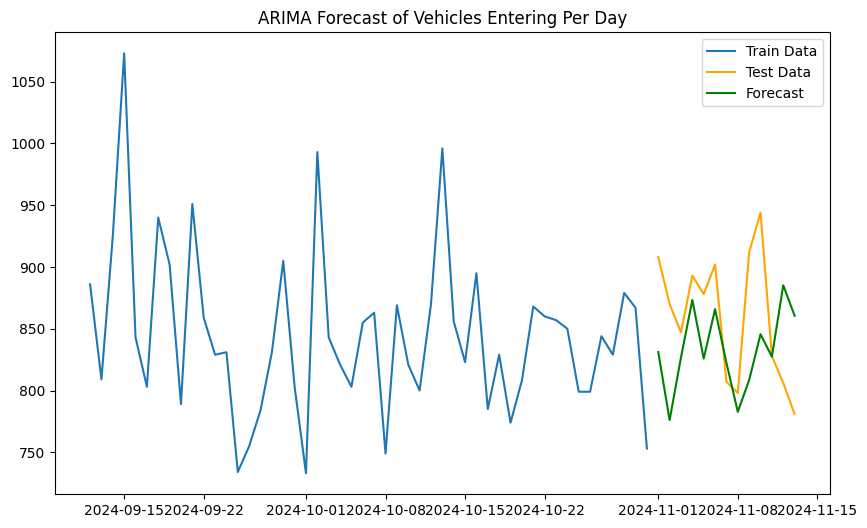

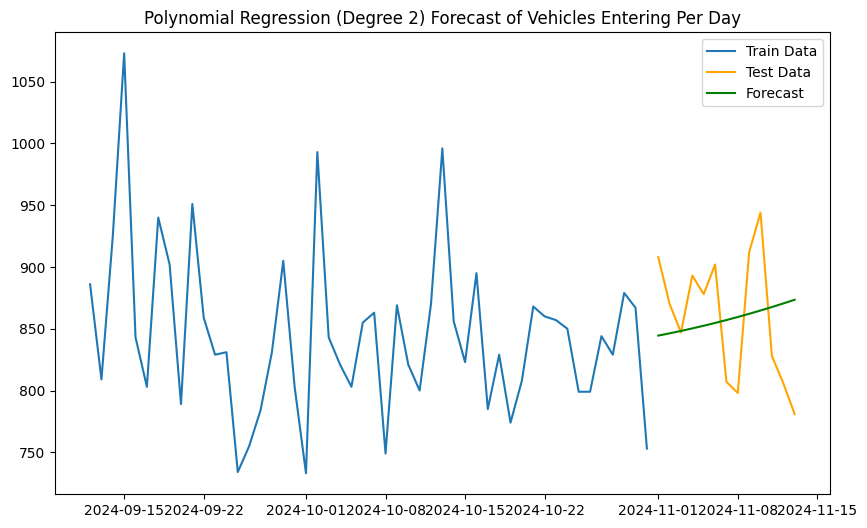

Part A: Forecast Total Number of Vehicles Entering Per Day
ARIMA MASE: 0.7468239558289926
ARIMA MAPE: 6.113643889997207
Polynomial Regression (Degree 2) MASE: 0.6931819763946463
Polynomial Regression (Degree 2) MAPE: 5.784750045155559


In [229]:

# ARIMA model for forecasting vehicles entering
arima_model = ARIMA(train_data, order=(2, 2, 4) , seasonal_order=(1,1,1,7))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test_data))

# Polynomial Regression for forecasting vehicles entering
degree = 2  # You can change the degree of the polynomial
X_train = np.arange(len(train_data)).reshape(-1, 1)
X_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, train_data)
poly_forecast = poly_model.predict(X_test)

# Plot ARIMA forecast
plot_series(train_data, test_data, arima_forecast, "ARIMA Forecast of Vehicles Entering Per Day")

# Plot Polynomial Regression forecast
plot_series(train_data, test_data, poly_forecast, f"Polynomial Regression (Degree {degree}) Forecast of Vehicles Entering Per Day")

# Evaluate models for Part A
print("Part A: Forecast Total Number of Vehicles Entering Per Day")
print("ARIMA MASE:", mase(test_data, arima_forecast, train_data))
print("ARIMA MAPE:", mape(test_data, arima_forecast))
print(f"Polynomial Regression (Degree {degree}) MASE:", mase(test_data, poly_forecast, train_data))
print(f"Polynomial Regression (Degree {degree}) MAPE:", mape(test_data, poly_forecast))

In [230]:
def forecast_arima(model_fit,test_len):
    forecast= model_fit.forecast(steps=test_len+1)
    forecast.sort_index(inplace=True)
    return forecast

In [231]:
def plot_forecasted_Data(data,months_to_predict,model_fit) :
    forecasted_data = forecast_arima(model_fit,months_to_predict)[1:]
    # Plotting for visualization of the forecasted data 
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data, label='Train', color='blue')
    plt.plot(forecasted_data.index, forecasted_data, label='Forecast', color='red')
    plt.legend()
    plt.title('ARIMA Forecast vs Actual')
    plt.show()
    return forecasted_data

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


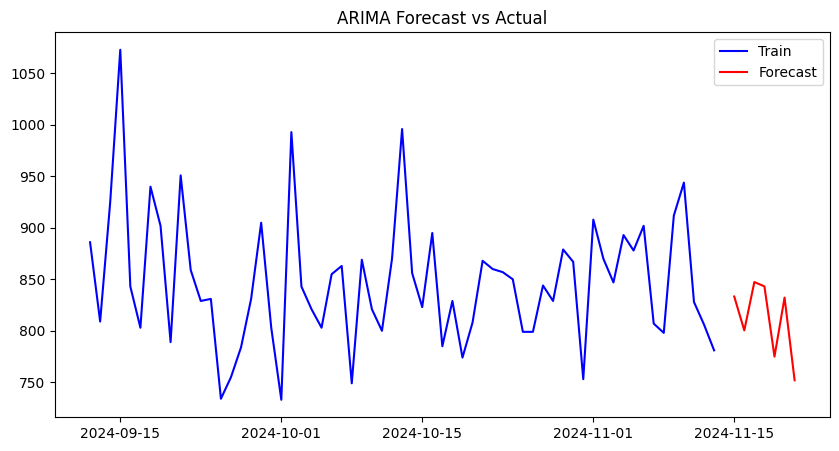

2024-11-15    833.306912
2024-11-16    800.400986
2024-11-17    847.407070
2024-11-18    843.151633
2024-11-19    774.930921
2024-11-20    832.278076
2024-11-21    751.943435
Freq: D, Name: predicted_mean, dtype: float64


In [232]:
model_fit = ARIMA(vehicles_per_day, order=(2, 2, 4) , seasonal_order=(1,1,1,7)).fit()
forecasted_data = plot_forecasted_Data(vehicles_per_day,7,model_fit)
print(forecasted_data)

In [233]:
# Forecasting for the average time spent by a vehicle
